In [1]:
from sklearn.cluster import KMeans, DBSCAN
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import geopandas as gpd
import warnings
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon


warnings.filterwarnings('ignore')
## 


def plot_spatial_and_seasonal_means(data):
    """
    plots the spatial mean of SWC over time in the first column and seasonal spatial means in the second and third columns.

    params:
    - data: xarray dataset containing the swc variable.
    """
    seasons = {
        'DJF': [12, 1, 2],
        'MAM': [3, 4, 5],
        'JJA': [6, 7, 8],
        'SON': [9, 10, 11]
    }
    
    levels = np.linspace(0.19, 0.26, 21)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    # overall spatial mean in (0,0)
    avg_swc_space = data['swc'].mean(dim='time')
    contour = axes[0, 0].contourf(data['lon'], data['lat'], avg_swc_space, cmap='BrBG', levels=levels, extend='both')
    axes[0, 0].set_title("Time Mean SWC")
    axes[0, 0].set_xlabel("Longitude")
    axes[0, 0].set_ylabel("Latitude")
    fig.colorbar(contour, ax=axes[0, 0], label="SWC")
    axes[0, 0].grid(True)

    # seasonal spatial means in (0,1), (0,2), (1,1), (1,2)
    positions = [(0, 1), (0, 2), (1, 1), (1, 2)]
    for idx, (season, months) in enumerate(seasons.items()):
        row, col = positions[idx]
        season_data = data.sel(time=data['time.month'].isin(months))
        spatial_mean = season_data['swc'].mean(dim='time')

        contour = axes[row, col].contourf(data['lon'], data['lat'], spatial_mean, cmap='BrBG', levels=levels, extend='both')
        axes[row, col].set_title(f"{season}: Spatial Mean of SWC")
        axes[row, col].set_xlabel("Longitude")
        axes[row, col].set_ylabel("Latitude")
        fig.colorbar(contour, ax=axes[row, col], label=f"SWC Mean ({season})")
        axes[row, col].grid(True)

    # Hide unused axes
    axes[1, 0].axis("off")

    plt.tight_layout()
    plt.show()

def plot_era5_and_planet(ds_era5, ds_planet):
    """
    plots mean SWC data from ERA5 and PlanetScope datasets with geographic bounds.

    params:
    - ds_era5: xarray dataset for ERA5 data.
    - ds_planet: xarray dataset for Planet data.
    """
    var_era5 = ds_era5['swvl1']
    var_planet = ds_planet['swc']

    swc_min_era5, swc_max_era5 = 0.1, 0.45

    lon_min, lon_max = ds_planet.lon.min().item(), ds_planet.lon.max().item()
    lat_min, lat_max = ds_planet.lat.min().item(), ds_planet.lat.max().item()

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # ERA5 full domain
    var_era5.mean(dim='time').plot(ax=axes[0, 0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
    axes[0, 0].set_title("ERA5 AOI 1990-2024")

    swc_mean = var_planet.mean(dim='time')
    non_nan_mask = ~np.isnan(swc_mean.values)
    lon_coords, lat_coords = np.meshgrid(swc_mean.lon.values, swc_mean.lat.values)
    non_nan_coords = np.column_stack([lon_coords[non_nan_mask], lat_coords[non_nan_mask]])

    if non_nan_coords.size > 0:
        hull = ConvexHull(non_nan_coords)
        polygon_coords = non_nan_coords[hull.vertices]
        poly_patch = Polygon(polygon_coords, closed=True, edgecolor='grey', facecolor='none', linewidth=1)
        axes[0, 0].add_patch(poly_patch)

    rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth=2, edgecolor='red', facecolor='none')
    axes[0, 0].add_patch(rect)

    try:
        var_era5_cropped = var_era5.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
        
        if var_era5_cropped.longitude.size == 0 or var_era5_cropped.latitude.size == 0:
            raise ValueError("Cropped ERA5 data has no valid longitude or latitude elements.")

        var_era5_cropped.mean(dim='time').plot(ax=axes[1, 0], cmap='viridis', vmin=swc_min_era5, vmax=swc_max_era5)
        axes[1, 0].set_title("Cropped ERA5")
        axes[1, 0].set_xlim(lon_min, lon_max)
        axes[1, 0].set_ylim(lat_min, lat_max)
    except Exception as e:
        print(f"Skipping cropped ERA5 plot due to error: {e}")
        axes[1, 0].set_title("Cropped ERA5 (Not Available)")
        axes[1, 0].axis("off")

    # Planet mean SWC cropped
    var_planet.mean(dim='time').plot(ax=axes[1, 1], cmap='plasma')
#    axes[1, 1].set_title(f"Cropped Planet {file_name}")

    plt.tight_layout()
    plt.show()

def perform_kmeans(data, n_clusters=7):
    """
    Perform K-Means clustering on SWC data.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - n_clusters: Number of clusters for K-Means.

    Returns:
    - cluster_map: 2D array with cluster labels reshaped to spatial dimensions (lat, lon).
    """
    # Prepare data for clustering: Flatten SWC values and remove NaNs
    swc_values = data['swc'].values.reshape(data.dims['time'], -1)
    swc_values_clean = np.nan_to_num(swc_values)  # Replace NaNs with zeros

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(swc_values_clean.T)  # Transpose to cluster spatially
    cluster_map = clusters.reshape(data.dims['lat'], data.dims['lon'])
    
    return cluster_map

def process_planet_folders_with_kmeans(path_planet_cantones, n_clusters=7):
    """
    Process all canton files and apply K-Means clustering to each.

    Parameters:
    - path_planet_cantones: Base path containing canton folders.
    - n_clusters: Number of clusters for K-Means.

    Returns:
    - A dictionary with file names as keys and cluster maps as values.
    """
    cluster_results = {}
    for folder in sorted(filter(lambda f: "canton" in f, os.listdir(path_planet_cantones))):
        folder_path = os.path.join(path_planet_cantones, folder)
        for file in sorted(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            try:
                data = xr.open_dataset(file_path)
                cluster_map = perform_kmeans(data, n_clusters=n_clusters)
                cluster_results[file] = cluster_map
                print(f"Processed K-Means for {file}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return cluster_results


def plot_all_clusters(cluster_results):
    """
    Plot all cluster maps in a single figure with subplots.

    Parameters:
    - cluster_results: Dictionary with file names as keys and cluster maps as values.
    """
    n_files = len(cluster_results)
    n_cols = 3
    n_rows = int(np.ceil(n_files / n_cols))

        
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'grey']
    cmap = ListedColormap(colors)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()

    for idx, (file_name, cluster_map) in enumerate(cluster_results.items()):
        ax = axes[idx]
        im = ax.imshow(cluster_map, cmap=cmap, origin="upper", vmin=0, vmax=7)
        ax.set_title(file_name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        fig.colorbar(im, ax=ax, label="Cluster ID")

    # Hide unused axes
    for ax in axes[len(cluster_results):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def compute_pca_clusters(data, cluster_map):
    """
    Computes the first two Principal Components (PC1 and PC2) for each cluster using the eofs library.

    Parameters:
    - data: xarray.Dataset containing the SWC variable.
    - cluster_map: 2D array with cluster labels corresponding to the spatial grid.

    Returns:
    - pc_results: Dictionary containing PC1 and PC2 for each cluster.
    """
    swc_values = data['swc'].values
    lon = data['lon'].values
    lat = data['lat'].values

    pc_results = {}

    for cluster_id in np.unique(cluster_map):
        cluster_indices = np.argwhere(cluster_map == cluster_id)

        if len(cluster_indices) > 1:  # Ensure enough data points exist for PCA
            # Extract the SWC data for the current cluster
            cluster_swc = np.array([
                swc_values[:, i, j] for i, j in cluster_indices
            ]).T

            # Standardize the data along the temporal axis
            standardized_data = StandardScaler().fit_transform(cluster_swc)

            # Apply EOF analysis
            solver = Eof(standardized_data)
            pc1 = solver.pcs(npcs=1, pcscaling=1).squeeze()
            pc2 = solver.pcs(npcs=2, pcscaling=1)[:, 1].squeeze()

            pc_results[cluster_id] = {
                'PC1': pc1,
                'PC2': pc2
            }

    return pc_results
    
def process_planet_folders(path_planet_cantones):
    """
    processes all datasets in folders containing 'canton' and returns a list of datasets.
    
    params:
    - path_planet_cantones: base path containing canton folders.

    returns:
    - a list of xarray datasets found in the specified folders.
    """

    datasets = []
    filenames = []
    for folder in sorted(filter(lambda f: "canton" in f, os.listdir(path_planet_cantones))):
        folder_path = os.path.join(path_planet_cantones, folder)
        for file in sorted(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            datasets.append(xr.open_dataset(file_path))
            filenames.append(file)
    return datasets, filenames
    


canton_104_2.nc
canton_105_2.nc
canton_106_2.nc
canton_107_2.nc
canton_120_2.nc
canton_121_2.nc
canton_122_2.nc
canton_124_2.nc
canton_125_2.nc
canton_126_2.nc
canton_127_2.nc
canton_128_2.nc
canton_129_2.nc
canton_158_2.nc
canton_162_2.nc


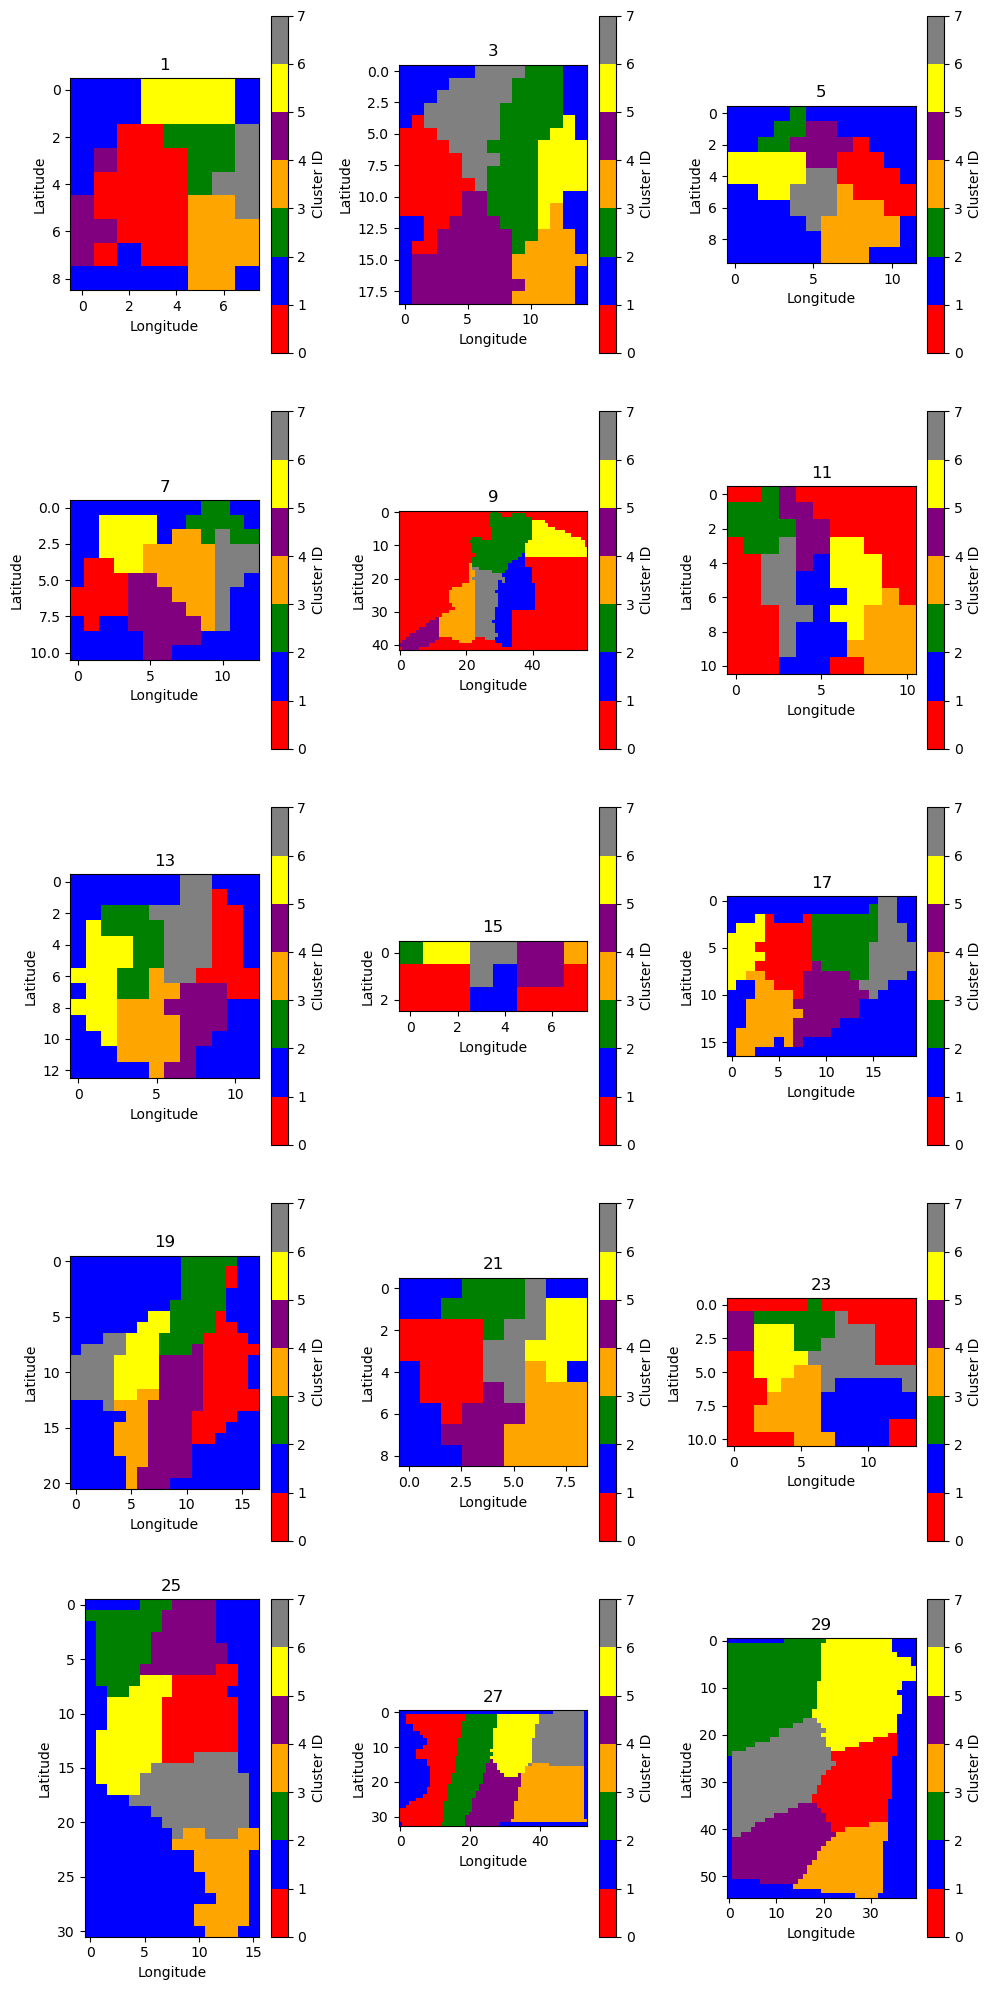

In [2]:
if __name__ == "__main__":
    path_planet_cantones = '../suyana/drought/swc/raw/'
    
    datasets, filenames = process_planet_folders(path_planet_cantones)
    n_clusters = 7

    file_path_era5 = './data/'
    ds_era5 = xr.open_dataset(file_path_era5 + 'merged_data_1990_2024_daily_means.nc')

    cluster_results = {}
    polygons = []
    
    if datasets:
        for idx, ds_planet in enumerate(datasets):
            
            if '_2.nc' in filenames[idx] and idx<31:
                print(filenames[idx])

                canton_id = filenames[idx]
                
                cluster_map = perform_kmeans(ds_planet, n_clusters=n_clusters)
                cluster_results[idx] = cluster_map

                lon = ds_planet["lon"].values
                lat = ds_planet["lat"].values

                for cluster_id in np.unique(cluster_map):
                    cluster_indices = np.argwhere(cluster_map == cluster_id)
                    points = [(lon[j], lat[i]) for i, j in cluster_indices]
                    if len(points) > 2:  # Minimum points required for a polygon
                        polygon = MultiPoint(points).convex_hull
                    else:
                        polygon = None
    
                    if polygon:
                        polygons.append({
                            "canton_id": canton_id,
                            "nro_cluster": int(cluster_id),
                            "polygon": polygon
                        })
    
    else:
        print("No datasets found in the specified folders.")

    if cluster_results:
        plot_all_clusters(cluster_results)


In [3]:
from eofs.xarray import Eof

def compute_eofs_for_canton(data):
    swc_values = data['swc']
    swc_filled = swc_values.fillna(0)  # Replace NaNs with 0

    if swc_filled.isnull().all():
        raise ValueError("All input data is missing after filling NaNs. Check your dataset.")

    coslat = np.cos(np.deg2rad(data.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]

    solver = Eof(swc_filled, weights=wgts)
    return solver

def get_eof_and_pc(solver, cant_modos=2, scaling_pc=1, scaling_eof=2):
    eof = solver.eofs(neofs=cant_modos, eofscaling=scaling_eof)
    pc = solver.pcs(npcs=cant_modos, pcscaling=scaling_pc)
    var_exp = solver.varianceFraction(neigs=cant_modos)
    return eof, pc, var_exp

def plot_eofs(eof, cant_modos=2):
    lat = eof.lat.values
    lon = eof.lon.values
    
    fig, axes = plt.subplots(1, cant_modos, figsize=(15, 5))
    if cant_modos == 1:
        axes = [axes]

    for i in range(cant_modos):
        eof_mode = eof.isel(mode=i).where(eof.isel(mode=i) != 0)
        im = axes[i].contourf(lon, lat, eof_mode, cmap='coolwarm', levels=11)
        axes[i].set_title(f'EOF Mode {i+1}')
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        plt.colorbar(im, ax=axes[i], orientation='vertical', label='EOF amplitude')

    plt.tight_layout()
    plt.show()

def plot_pcs(pc, cant_modos=2):
    fig, axes = plt.subplots(cant_modos, 1, figsize=(6, 3 * cant_modos))
    if cant_modos == 1:
        axes = [axes]

    for i in range(cant_modos):
        pc_mode = pc[:, i]
        axes[i].plot(pc_mode, label=f'PC Mode {i+1}')
        axes[i].set_title(f'Principal Component {i+1}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Amplitude')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_variance_explained(var_exp, cant_modos=2):
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, cant_modos + 1), var_exp * 100, tick_label=[f'Mode {i}' for i in range(1, cant_modos + 1)])
    plt.title('Variance explained by EOF modes')
    plt.xlabel('EOF Mode')
    plt.ylabel('Variance explained (%)')
    plt.grid(True)
    plt.show()

canton_104_2.nc


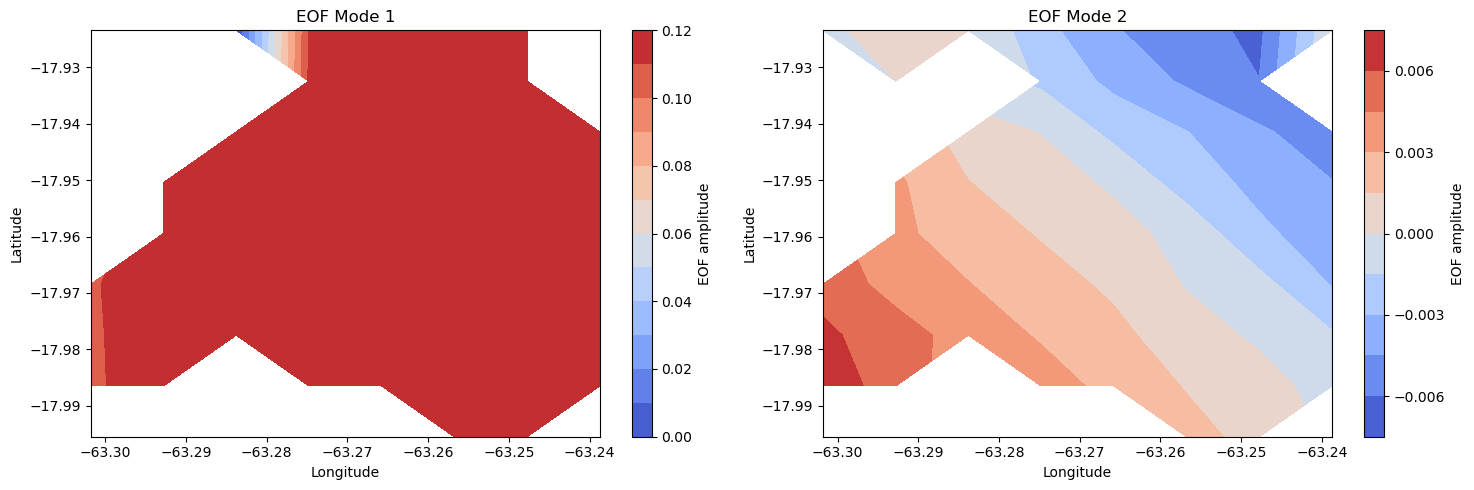

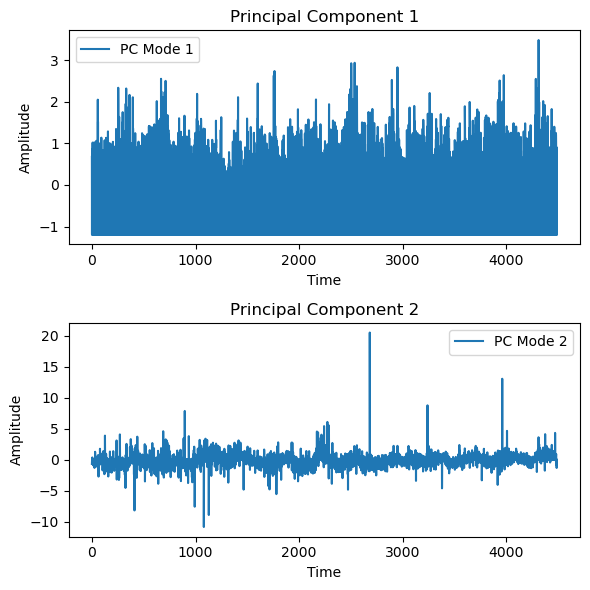

canton_105_2.nc


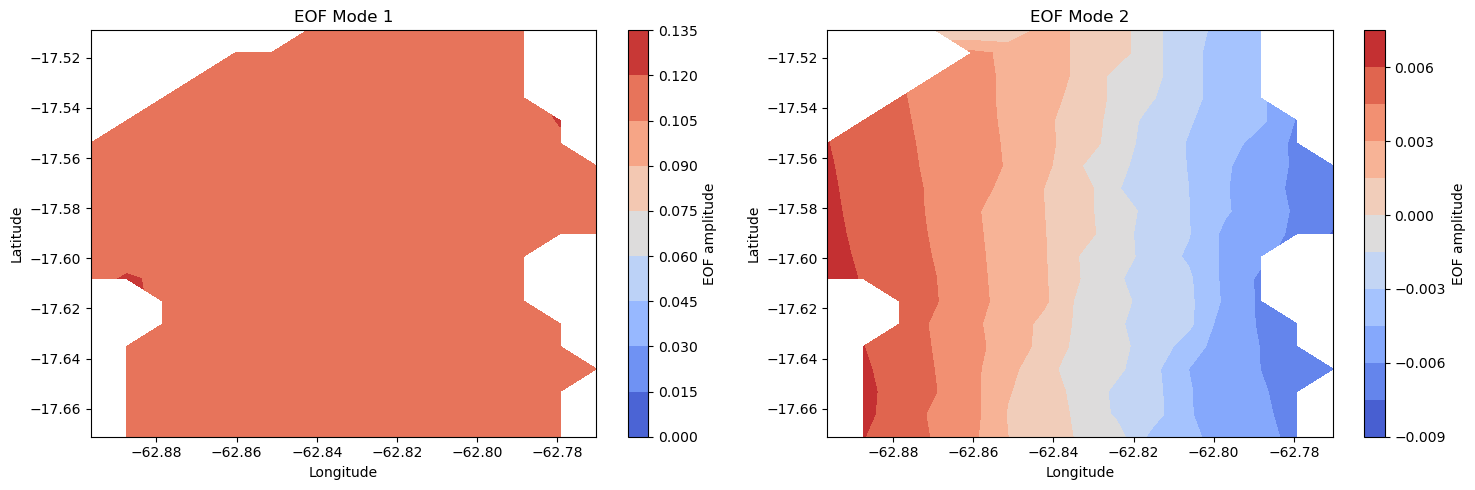

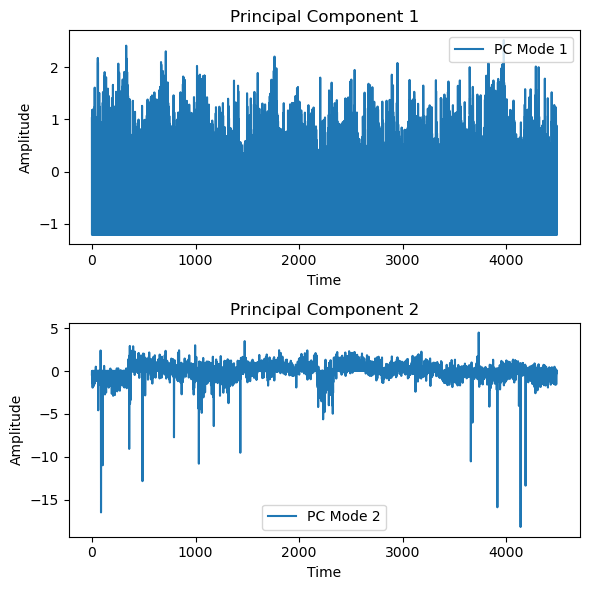

canton_106_2.nc


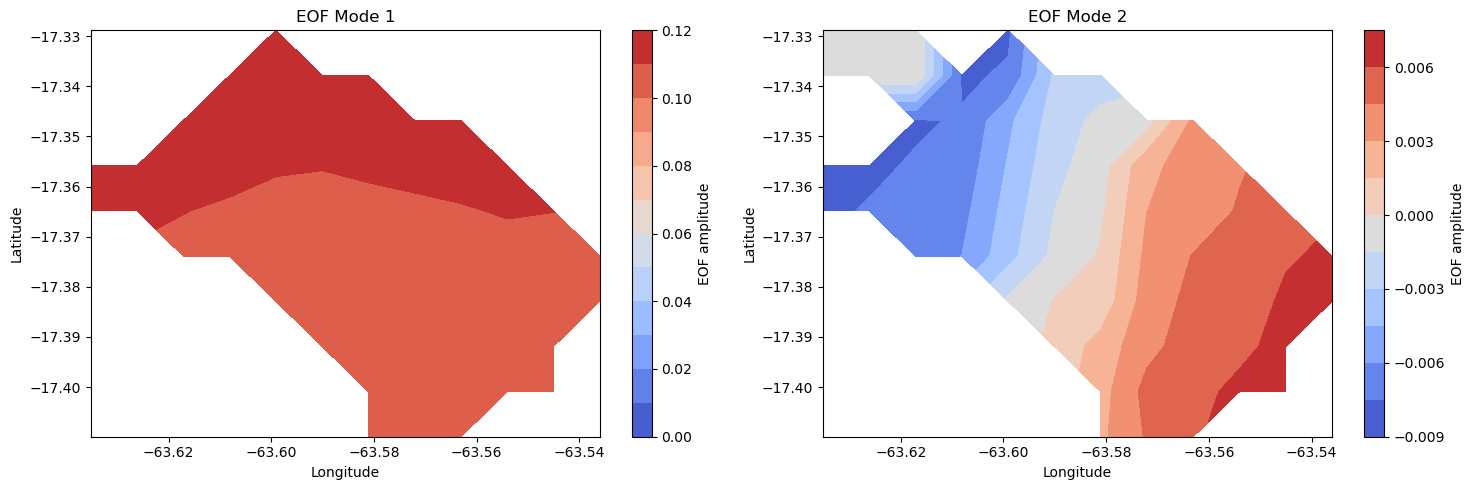

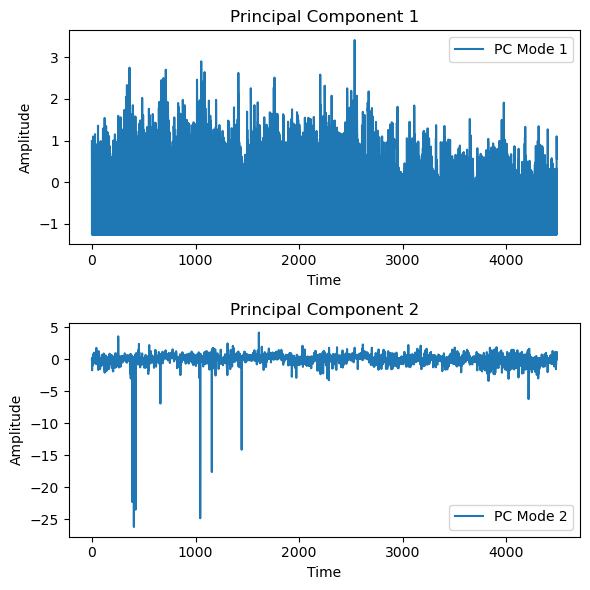

canton_107_2.nc


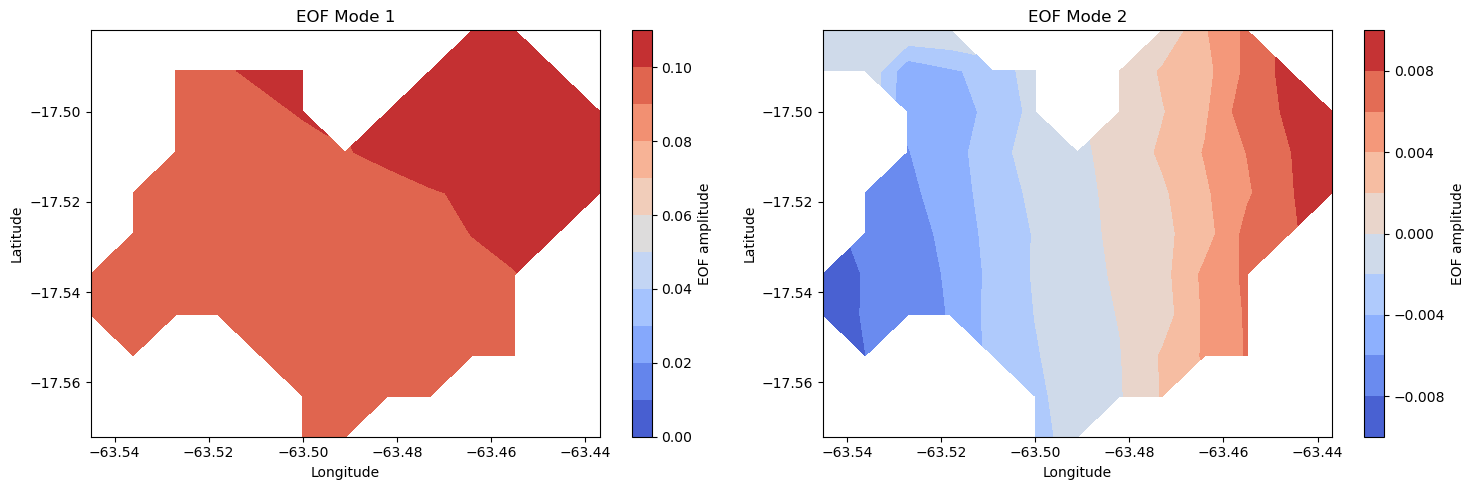

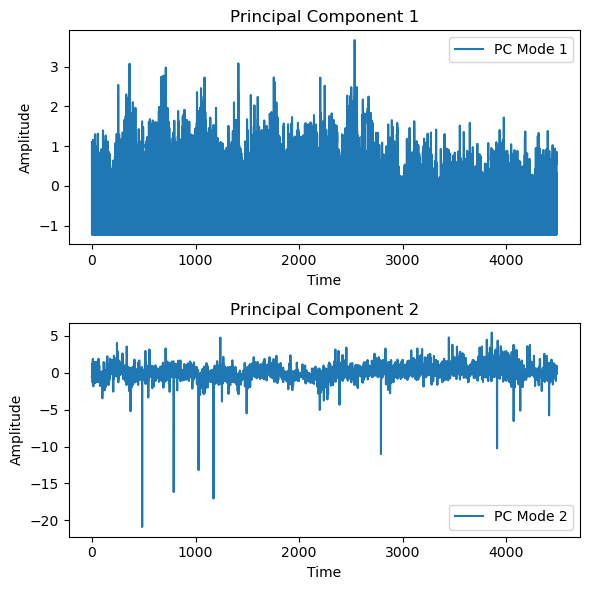

canton_120_2.nc


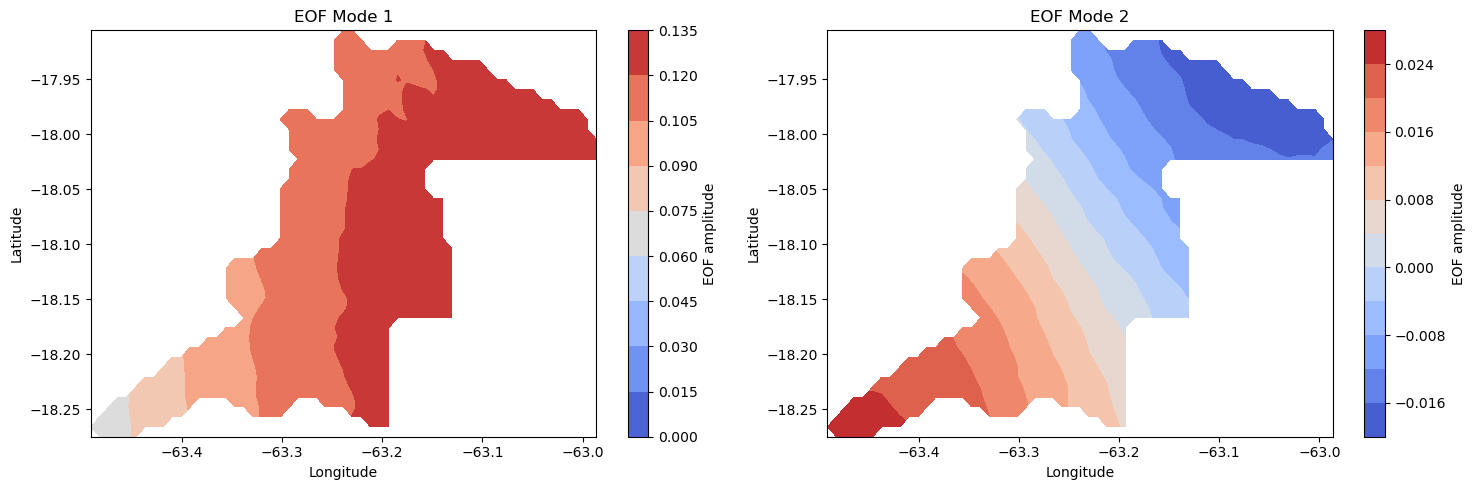

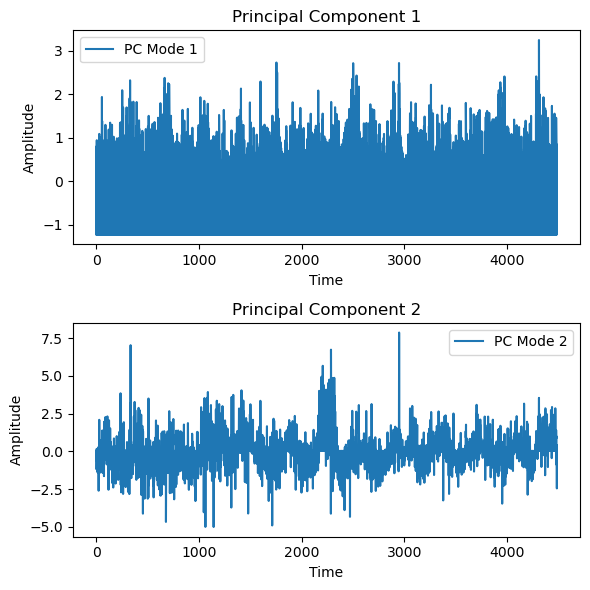

canton_121_2.nc


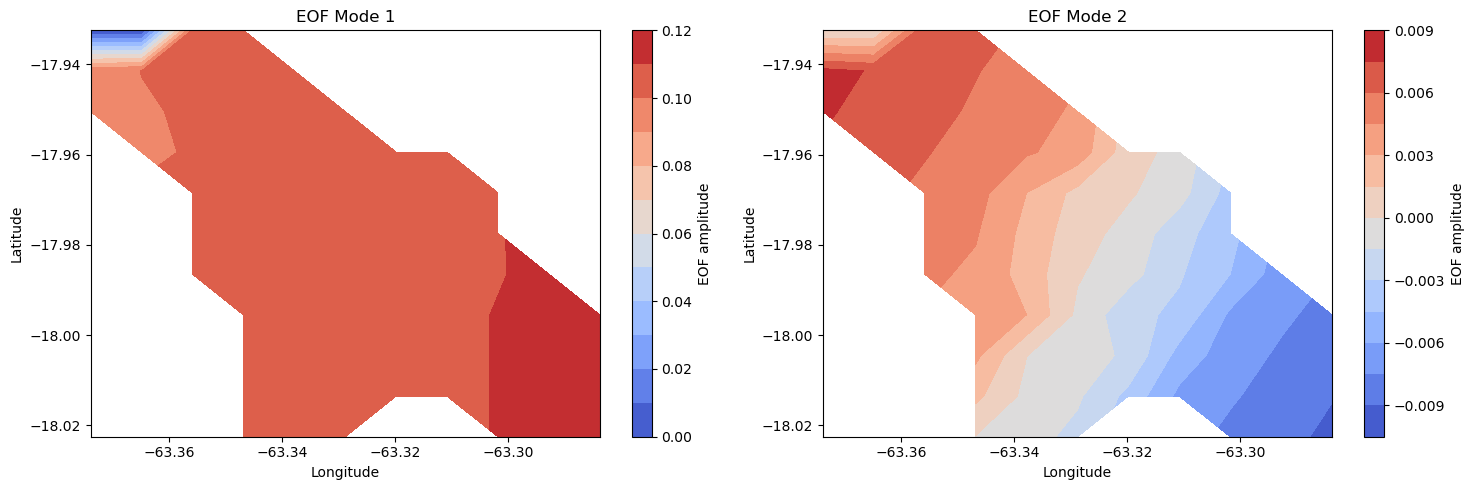

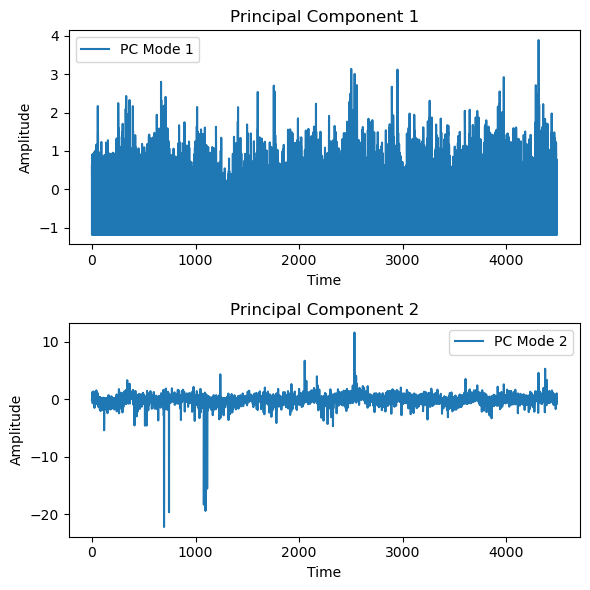

canton_122_2.nc


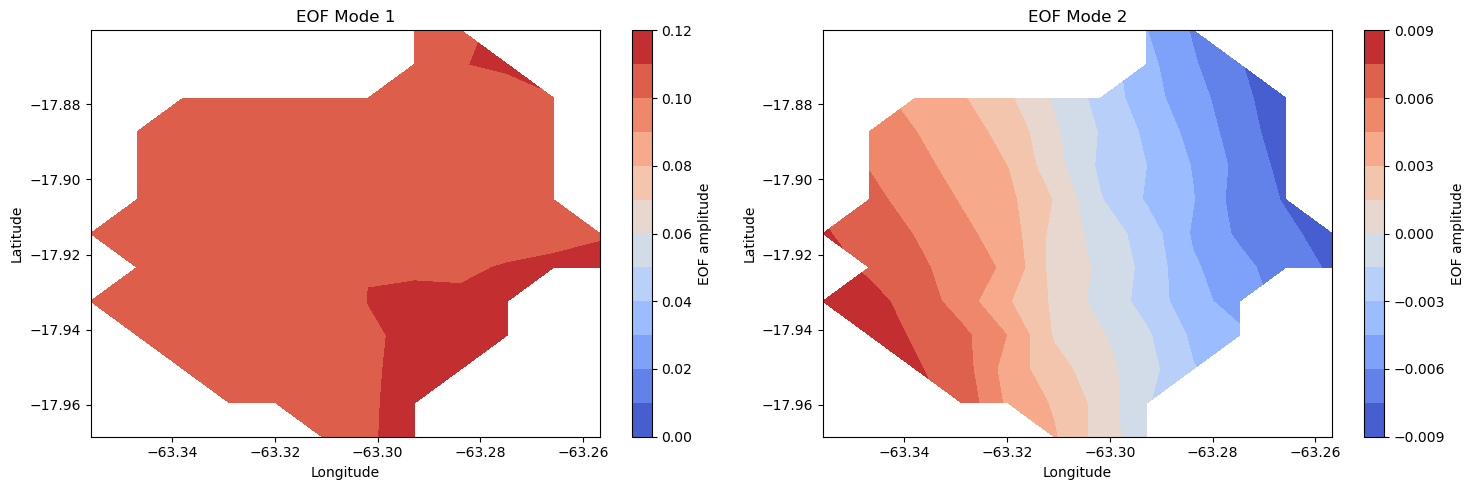

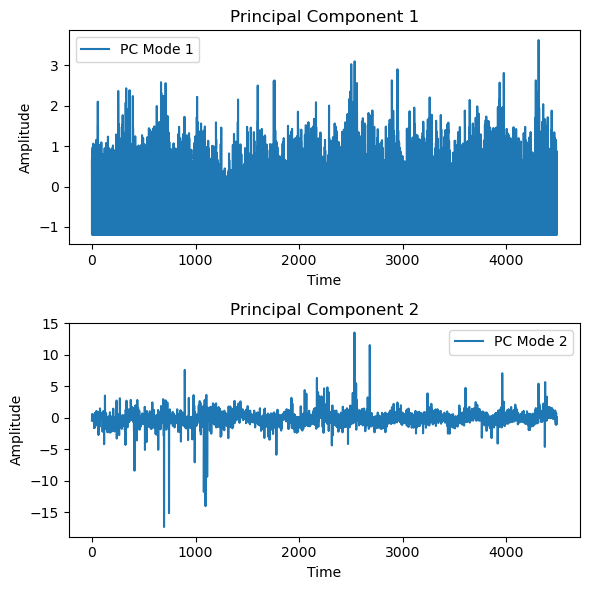

canton_124_2.nc


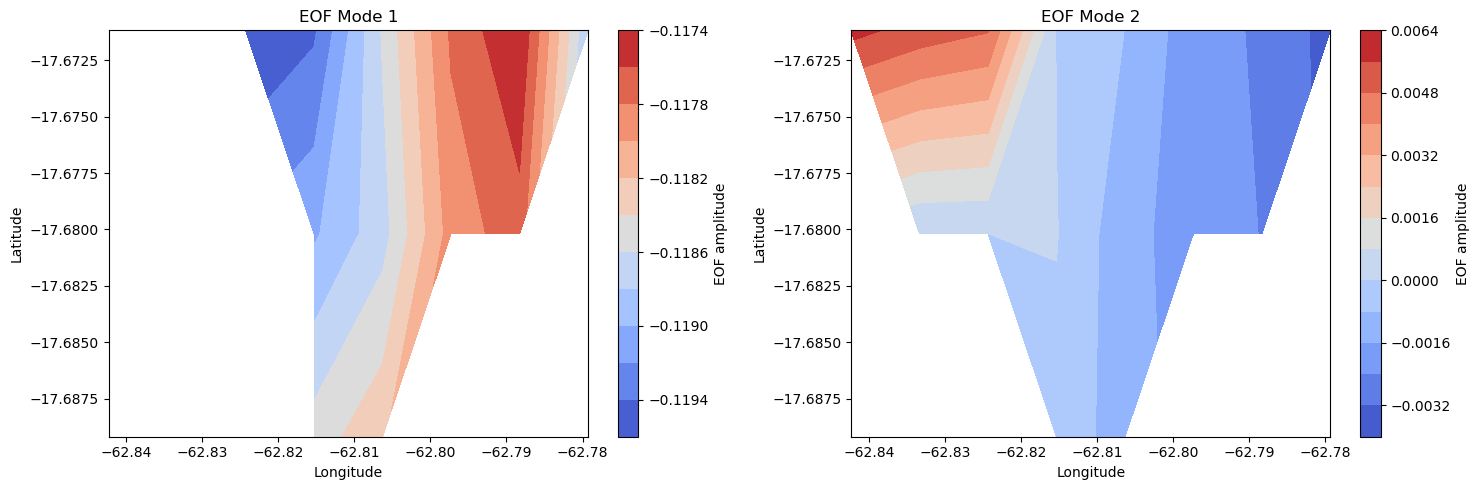

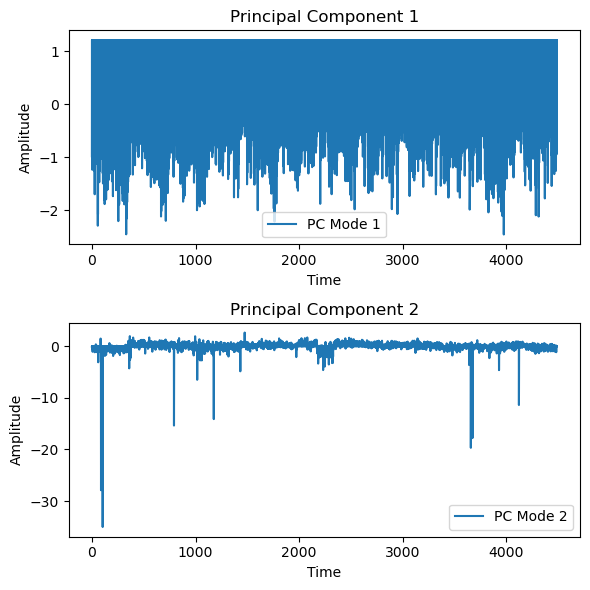

canton_125_2.nc


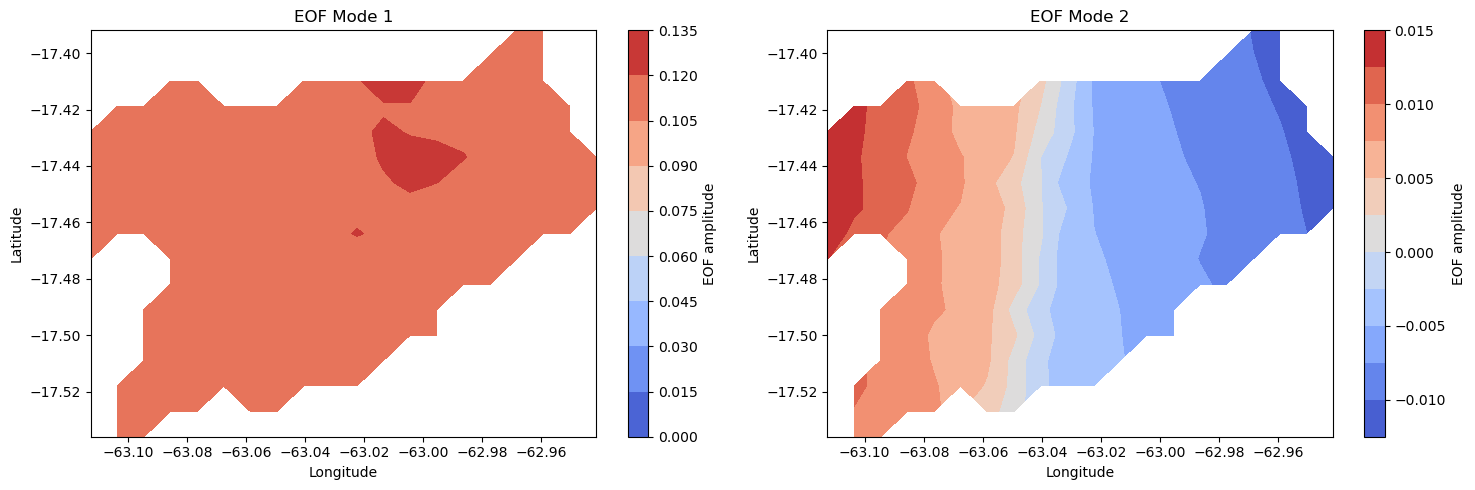

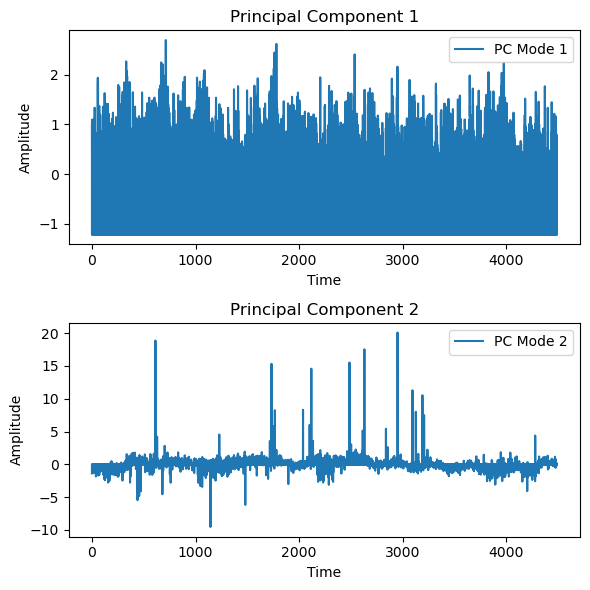

canton_126_2.nc


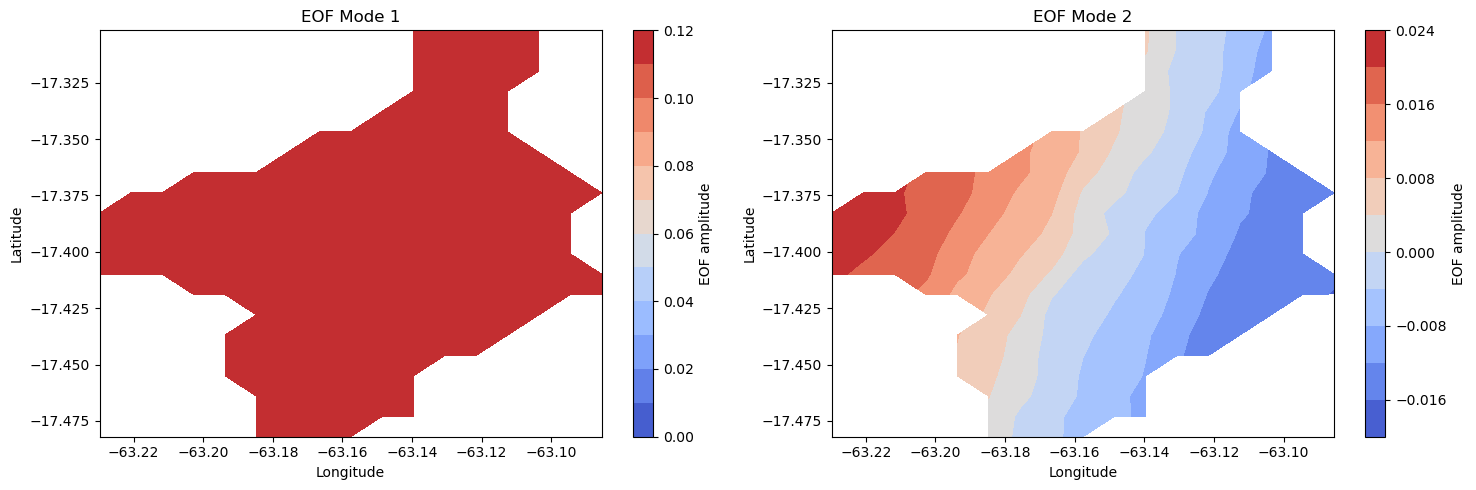

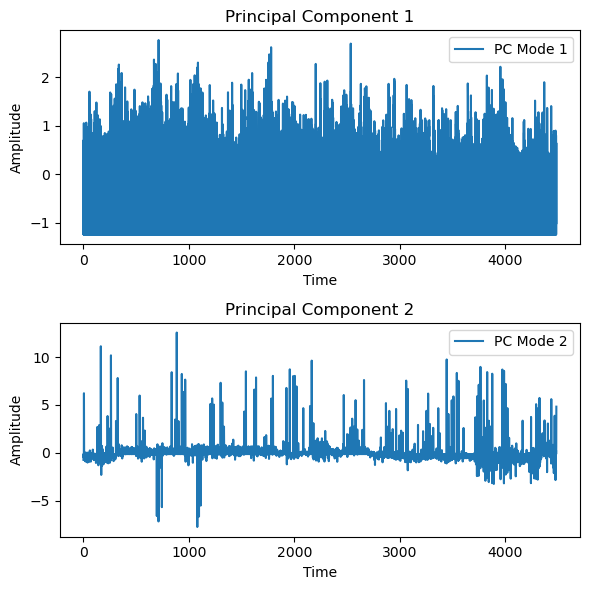

canton_127_2.nc


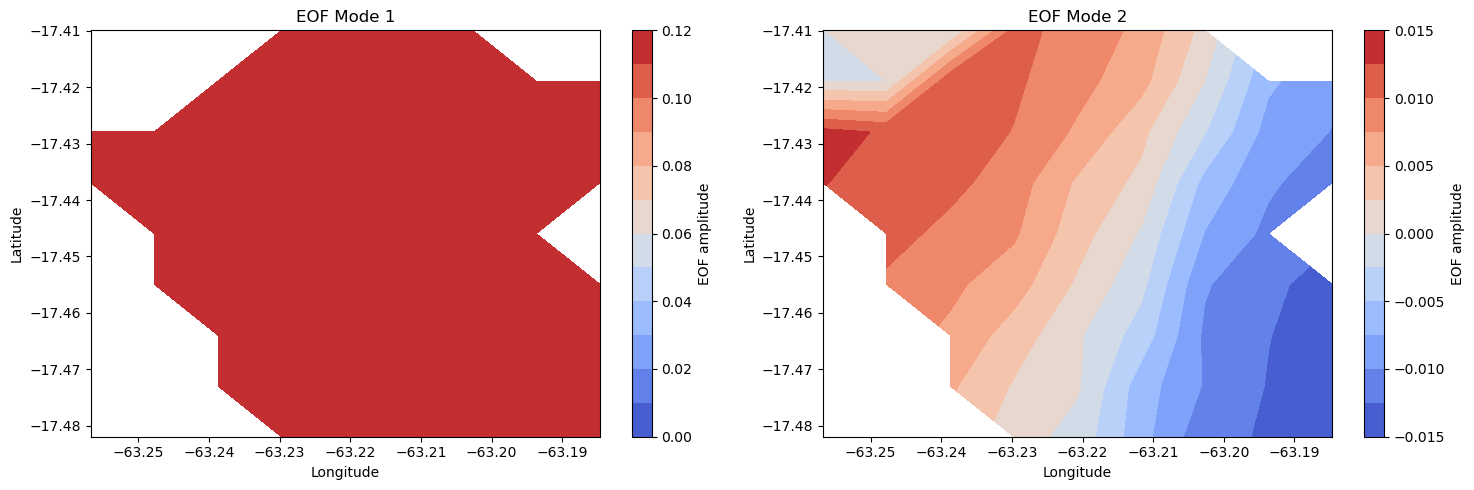

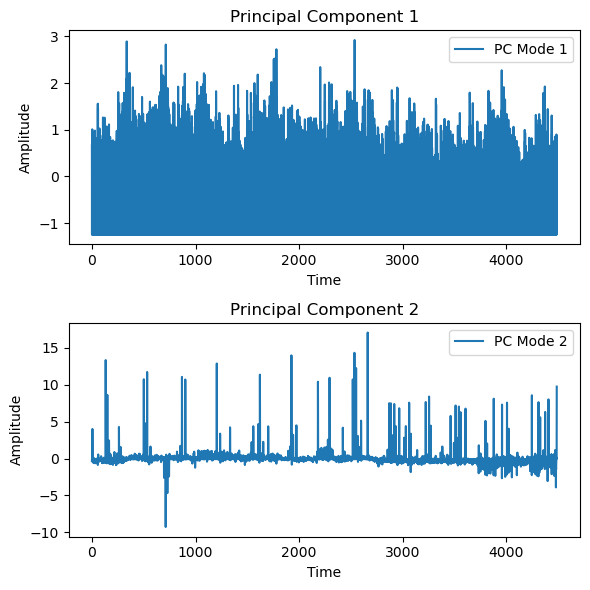

canton_128_2.nc


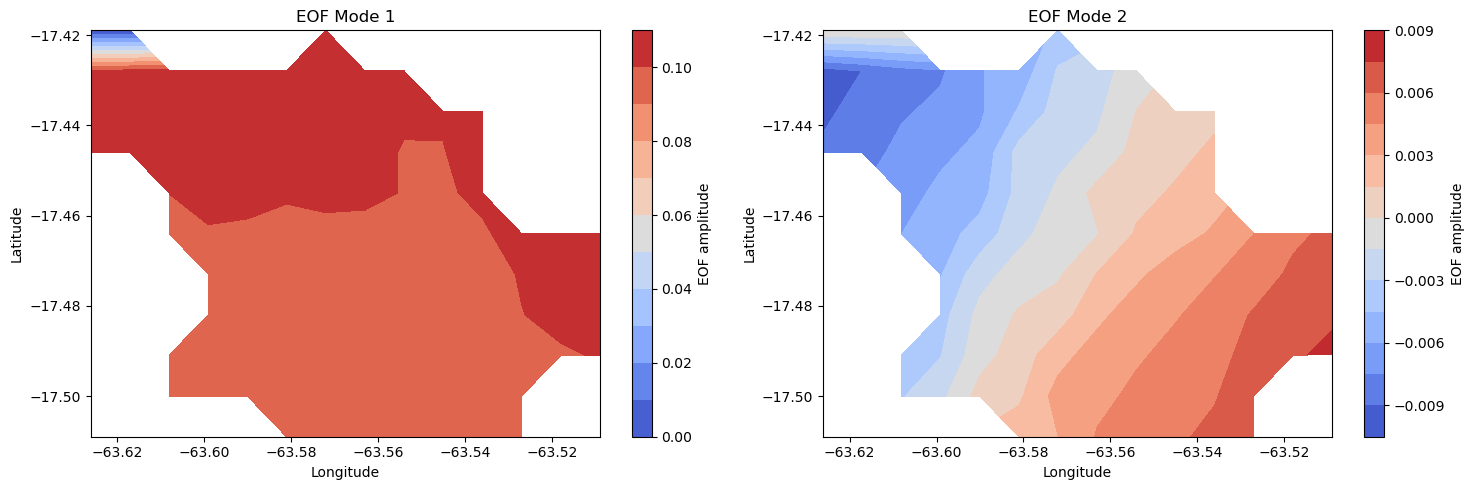

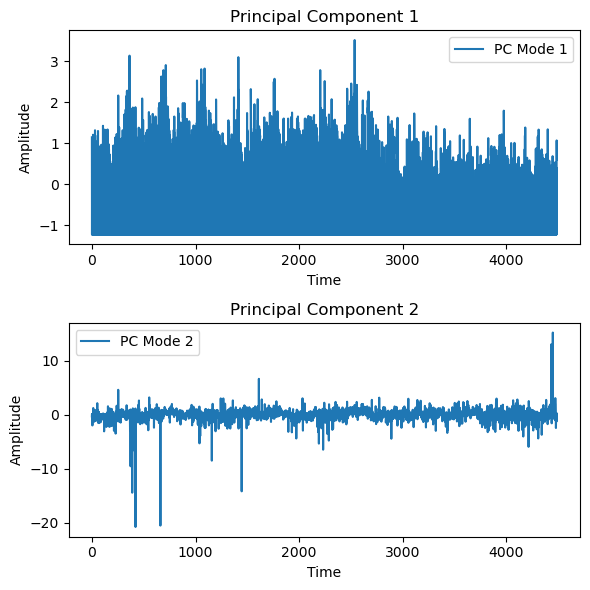

canton_129_2.nc


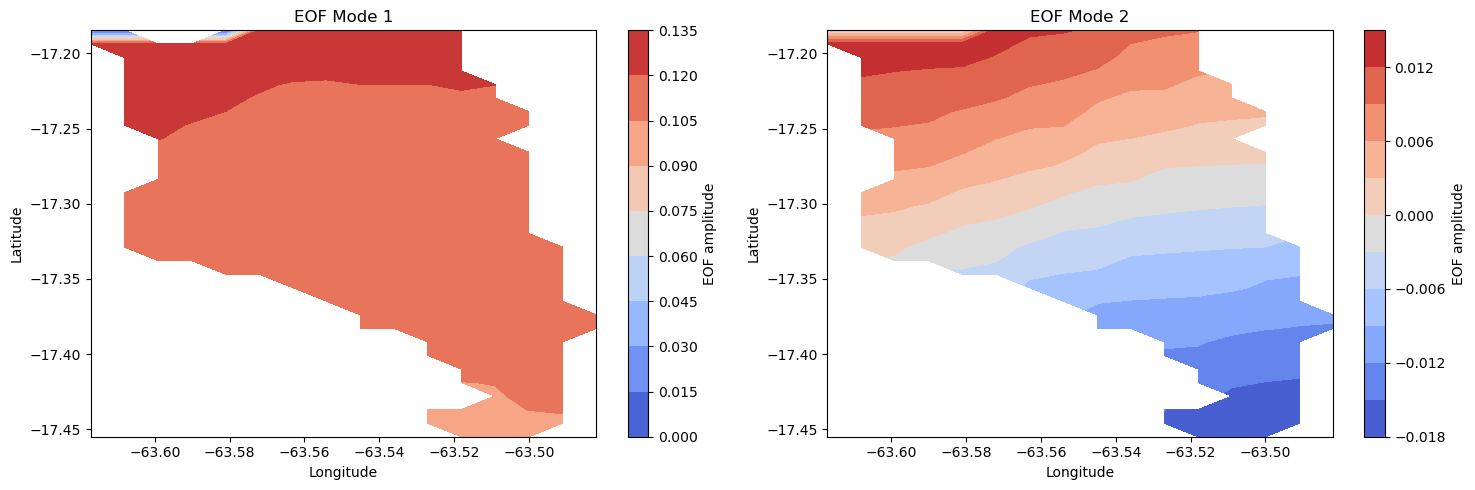

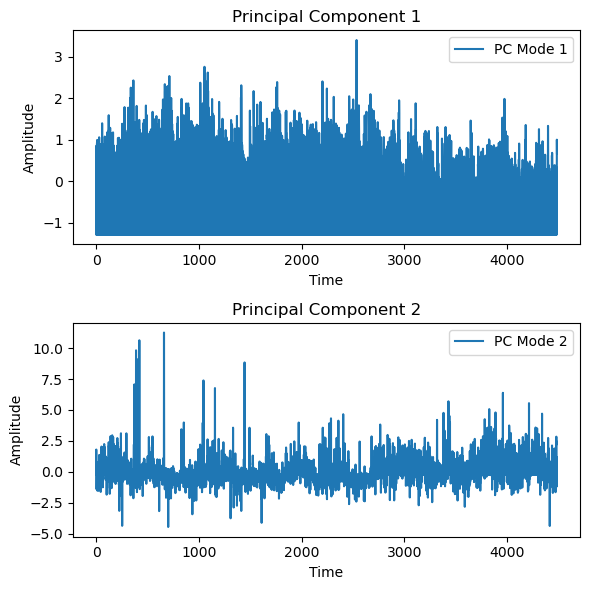

canton_158_2.nc


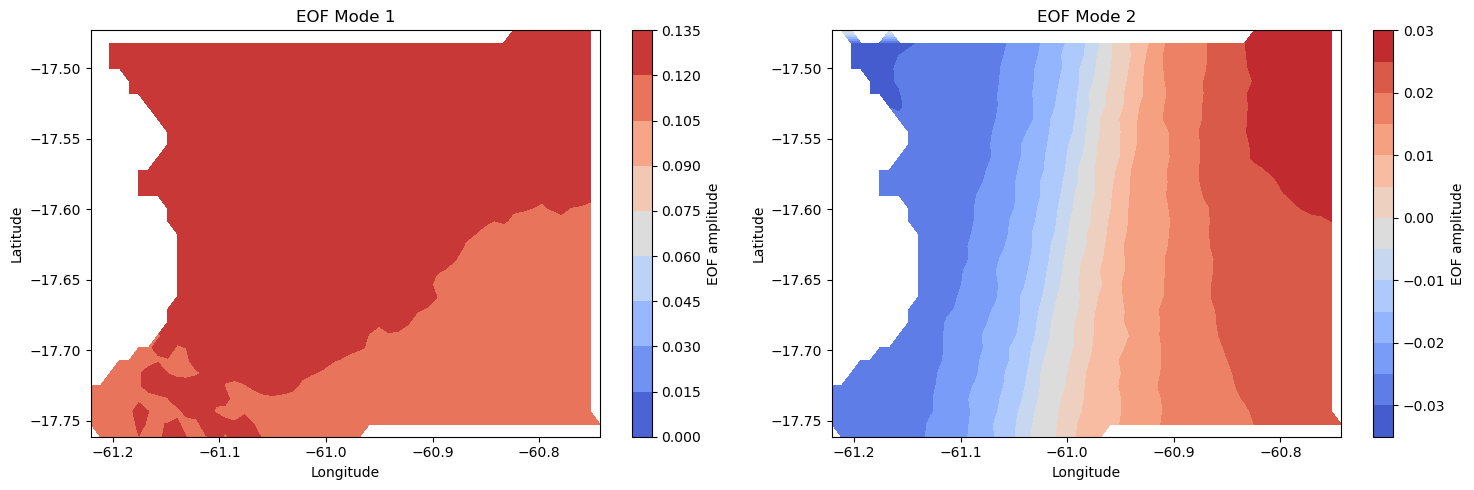

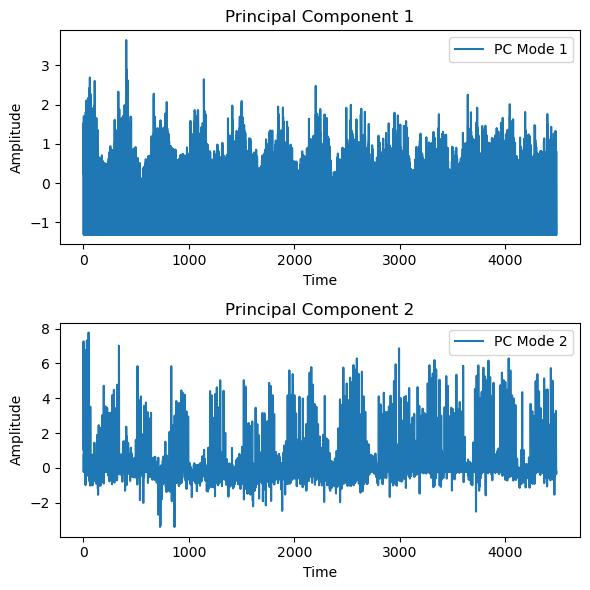

canton_162_2.nc


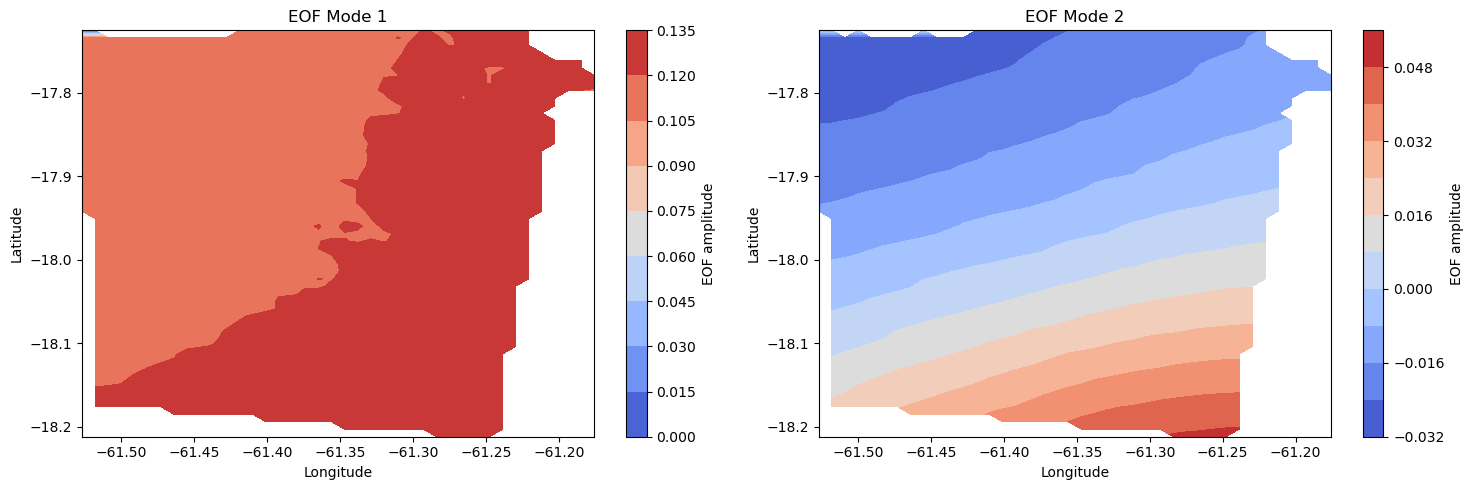

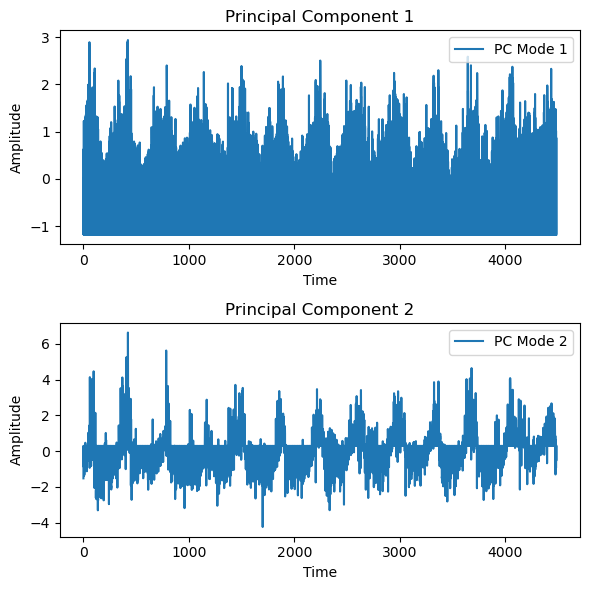

In [4]:
for idx, ds_planet in enumerate(datasets):
            
    if '_2.nc' in filenames[idx] and idx<30:
        print(filenames[idx])
        data = datasets[idx]

        solver = compute_eofs_for_canton(data)
        eof, pc, var_exp = get_eof_and_pc(solver, cant_modos=2, scaling_pc=1, scaling_eof=2)
        
        plot_eofs(eof, cant_modos=2)
        plot_pcs(pc, cant_modos=2)
                


canton_163_2.nc


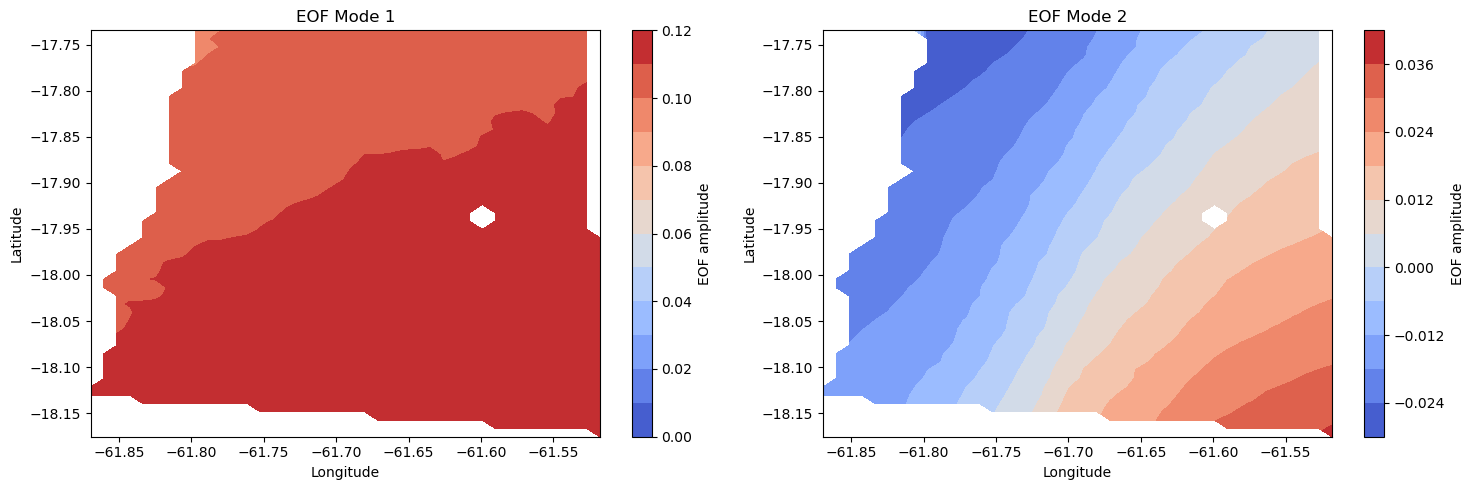

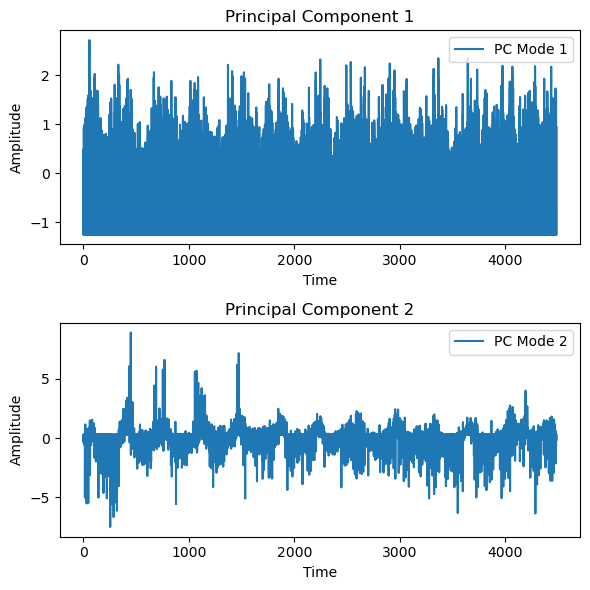

In [5]:
i=31
print(filenames[i])

data = datasets[i]

solver = compute_eofs_for_canton(data)
eof, pc, var_exp = get_eof_and_pc(solver, cant_modos=2, scaling_pc=1, scaling_eof=2)

plot_eofs(eof, cant_modos=2)
plot_pcs(pc, cant_modos=2)
#plot_variance_explained(var_exp, cant_modos=2)